In [1]:
import sys
sys.path.append('../')
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import glob

from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TerminateOnNaN, CSVLogger, TensorBoard
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

from models.keras_ssd512_Siamese import ssd_512
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation, SSDDataAugmentation_Siamese
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms


img_height = 512  # Height of the model input images
img_width = 512  # Width of the model input images
img_channels = 3  # Number of color channels of the model input images
mean_color = [123, 117, 104]  # Per-channel mean of images. Do not change if use any of the pre-trained weights.
# The color channel order in the original SSD is BGR,
# so we'll have the model reverse the color channel order of the input images.
swap_channels = [2, 1, 0]
# The anchor box scaling factors used in the original SSD512 for the Pascal VOC datasets
# scales_pascal =
# The anchor box scaling factors used in the original SSD512 for the MS COCO datasets
scales_coco = [0.07, 0.15, 0.3, 0.45, 0.6, 0.75, 0.9, 1.05]
scales = scales_coco
aspect_ratios = [[1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5]]  # The anchor box aspect ratios used in the original SSD512; the order matters
two_boxes_for_ar1 = True
steps = [8, 16, 32, 64, 128, 256, 512]  # Space between two adjacent anchor box center points for each predictor layer.
# The offsets of the first anchor box center points from the top and left borders of the image
# as a fraction of the step size for each predictor layer.
offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
clip_boxes = False  # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
# The variances by which the encoded target coordinates are divided as in the original implementation
variances = [0.1, 0.1, 0.2, 0.2]
normalize_coords = True
Model_Build = 'New_Model'  # 'Load_Model'
Optimizer_Type = 'SGD'  # 'Adam'  #
# Different batch_size will have different prediction loss.
batch_size = 8  # Change the batch size if you like, or if you run into GPU memory issues.
# alpha_distance = 0.0001  # Coefficient for the distance between the source and target feature maps.
loss_weights = [10.0, 10.0, 0.0] + [1.0]
experiment = 'MMD_pool1pool2_weight10'

#  
DatasetName = 'SIM10K_to_City_resize_400_800' # 'City_to_foggy0_01_resize_400_800'  # 'SIM10K_to_VOC07_resize_400_800' #   'SIM10K_to_VOC12_resize_400_800'
processed_dataset_path = './processed_dataset_h5/' + DatasetName
if not os.path.exists(processed_dataset_path):
    os.makedirs(processed_dataset_path)

if len(glob.glob(os.path.join(processed_dataset_path, '*.h5'))):
    Dataset_Build = 'Load_Dataset'
else:
    Dataset_Build = 'New_Dataset'

# Define model callbacks.
checkpoint_path = os.path.join('../trained_weights', DatasetName, experiment)
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)    
    
if DatasetName == 'SIM10K_to_VOC12_resize_400_800':
    resize_image_to = (400, 800)
    # The directories that contain the images.
    train_source_images_dir = '../../datasets/SIM10K/JPEGImages'
    train_target_images_dir = '../../datasets/VOCdevkit/VOC2012/JPEGImages'
    test_target_images_dir = '../../datasets/VOCdevkit/VOC2012/JPEGImages'

    # The directories that contain the annotations.
    train_annotation_dir = '../../datasets/SIM10K/Annotations'
    test_annotation_dir = '../../datasets/VOCdevkit/VOC2012/Annotations'

    # The paths to the image sets.
    train_source_image_set_filename = '../../datasets/SIM10K/ImageSets/Main/trainval10k.txt'
    # The trainset of VOC which has 'car' object is used as train_target.
    train_target_image_set_filename = '../../datasets/VOCdevkit/VOC2012_CAR/ImageSets/Main/train_target.txt'
    # The valset of VOC which has 'car' object is used as test.
    test_target_image_set_filename = '../../datasets/VOCdevkit/VOC2012_CAR/ImageSets/Main/test.txt'

    classes = ['background', 'car']  # Our model will produce predictions for these classes.
    train_classes = ['background', 'car', 'motorbike', 'person']  # The train_source dataset contains these classes.
    train_include_classes = [train_classes.index(one_class) for one_class in classes[1:]]
    # The test_target dataset contains these classes.
    val_classes = ['background', 'car',
                   'aeroplane', 'bicycle', 'bird', 'boat',
                   'bottle', 'bus', 'cat',
                   'chair', 'cow', 'diningtable', 'dog',
                   'horse', 'motorbike', 'person', 'pottedplant',
                   'sheep', 'sofa', 'train', 'tvmonitor']
    val_include_classes = [val_classes.index(one_class) for one_class in classes[1:]]
    # Number of positive classes, 8 for domain Cityscapes, 20 for Pascal VOC, 80 for MS COCO, 1 for SIM10K
    n_classes = len(classes) - 1
    
elif DatasetName == 'SIM10K_to_VOC07_resize_400_800':
    resize_image_to = (400, 800)
    # The directories that contain the images.
    train_source_images_dir = '../../datasets/SIM10K/JPEGImages'
    train_target_images_dir = '../../datasets/VOCdevkit/VOC2007/JPEGImages'
    test_target_images_dir = '../../datasets/VOCdevkit/VOC2007/JPEGImages'

    # The directories that contain the annotations.
    train_annotation_dir = '../../datasets/SIM10K/Annotations'
    test_annotation_dir = '../../datasets/VOCdevkit/VOC2007/Annotations'

    # The paths to the image sets.
    train_source_image_set_filename = '../../datasets/SIM10K/ImageSets/Main/trainval10k.txt'
    # The trainset of VOC which has 'car' object is used as train_target.
    train_target_image_set_filename = '../../datasets/VOCdevkit/VOC2007_CAR/ImageSets/Main/train_target.txt'
    # The valset of VOC which has 'car' object is used as test.
    test_target_image_set_filename = '../../datasets/VOCdevkit/VOC2007_CAR/ImageSets/Main/test.txt'

    classes = ['background', 'car']  # Our model will produce predictions for these classes.
    train_classes = ['background', 'car', 'motorbike', 'person']  # The train_source dataset contains these classes.
    train_include_classes = [train_classes.index(one_class) for one_class in classes[1:]]
    # The test_target dataset contains these classes.
    val_classes = ['background', 'car',
                   'aeroplane', 'bicycle', 'bird', 'boat',
                   'bottle', 'bus', 'cat',
                   'chair', 'cow', 'diningtable', 'dog',
                   'horse', 'motorbike', 'person', 'pottedplant',
                   'sheep', 'sofa', 'train', 'tvmonitor']
    val_include_classes = [val_classes.index(one_class) for one_class in classes[1:]]
    # Number of positive classes, 8 for domain Cityscapes, 20 for Pascal VOC, 80 for MS COCO, 1 for SIM10K
    n_classes = len(classes) - 1

elif DatasetName == 'SIM10K_to_City_resize_400_800':
    resize_image_to = (400, 800)
    # The directories that contain the images.
    train_source_images_dir = '../../datasets/SIM10K/JPEGImages'
    train_target_images_dir = '../../datasets/Cityscapes/JPEGImages'
    test_target_images_dir = '../../datasets/val_data_for_SIM10K_to_cityscapes/JPEGImages'

    # The directories that contain the annotations.
    train_annotation_dir = '../../datasets/SIM10K/Annotations'
    test_annotation_dir = '../../datasets/val_data_for_SIM10K_to_cityscapes/Annotations'

    # The paths to the image sets.
    train_source_image_set_filename = '../../datasets/SIM10K/ImageSets/Main/trainval10k.txt'
    train_target_image_set_filename = '../../datasets/Cityscapes/ImageSets/Main/train_source.txt'
    test_target_image_set_filename = '../../datasets/val_data_for_SIM10K_to_cityscapes/ImageSets/Main/test.txt'

    classes = ['background', 'car']  # Our model will produce predictions for these classes.
    train_classes = ['background', 'car', 'motorbike', 'person']  # The train_source dataset contains these classes.
    train_include_classes = [train_classes.index(one_class) for one_class in classes[1:]]
    # The test_target dataset contains these classes.
    val_classes = ['background', 'car']
    val_include_classes = 'all'
    # Number of positive classes, 8 for domain Cityscapes, 20 for Pascal VOC, 80 for MS COCO, 1 for SIM10K
    n_classes = len(classes) - 1

elif DatasetName == 'City_to_foggy0_02_resize_400_800':
    resize_image_to = (400, 800)
    # Introduction of PascalVOC: https://arleyzhang.github.io/articles/1dc20586/
    # The directories that contain the images.
    train_source_images_dir = '../../datasets/Cityscapes/JPEGImages'
    train_target_images_dir = '../../datasets/Cityscapes/JPEGImages'
    test_target_images_dir = '../../datasets/Cityscapes/JPEGImages'

    # The directories that contain the annotations.
    train_annotation_dir = '../../datasets/Cityscapes/Annotations'
    test_annotation_dir = '../../datasets/Cityscapes/Annotations'

    # The paths to the image sets.
    train_source_image_set_filename = '../../datasets/Cityscapes/ImageSets/Main/train_source.txt'
    train_target_image_set_filename = '../../datasets/Cityscapes/ImageSets/Main/train_target.txt'
    test_target_image_set_filename = '../../datasets/Cityscapes/ImageSets/Main/test.txt'
    # Our model will produce predictions for these classes.
    classes = ['background',
               'person', 'rider', 'car', 'truck',
               'bus', 'train', 'motorcycle', 'bicycle']
    train_classes = classes
    train_include_classes = 'all'
    val_classes = classes
    val_include_classes = 'all'
    # Number of positive classes, 8 for domain Cityscapes, 20 for Pascal VOC, 80 for MS COCO, 1 for SIM10K
    n_classes = len(classes) - 1

elif DatasetName == 'City_to_foggy0_01_resize_400_800':
    resize_image_to = (400, 800)
    # Introduction of PascalVOC: https://arleyzhang.github.io/articles/1dc20586/
    # The directories that contain the images.
    train_source_images_dir = '../../datasets/Cityscapes/JPEGImages'
    train_target_images_dir = '../../datasets/CITYSCAPES_beta_0_01/JPEGImages'
    test_target_images_dir = '../../datasets/CITYSCAPES_beta_0_01/JPEGImages'

    # The directories that contain the annotations.
    train_annotation_dir = '../../datasets/Cityscapes/Annotations'
    test_annotation_dir = '../../datasets/Cityscapes/Annotations'

    # The paths to the image sets.
    train_source_image_set_filename = '../../datasets/Cityscapes/ImageSets/Main/train_source.txt'
    train_target_image_set_filename = '../../datasets/Cityscapes/ImageSets/Main/train_target.txt'
    test_target_image_set_filename = '../../datasets/Cityscapes/ImageSets/Main/test.txt'
    # Our model will produce predictions for these classes.
    classes = ['background',
               'person', 'rider', 'car', 'truck',
               'bus', 'train', 'motorcycle', 'bicycle']
    train_classes = classes
    train_include_classes = 'all'
    val_classes = classes
    val_include_classes = 'all'
    # Number of positive classes, 8 for domain Cityscapes, 20 for Pascal VOC, 80 for MS COCO, 1 for SIM10K
    n_classes = len(classes) - 1

else:
    raise ValueError('Undefined dataset name.')

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
if Model_Build == 'New_Model':
    # 1: Build the Keras model.

    K.clear_session()  # Clear previous models from memory.

    import tensorflow as tf
    from keras.backend.tensorflow_backend import set_session
    
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
    config.log_device_placement = True  # to log device placement (on which device the operation ran)
    # (nothing gets printed in Jupyter, only if you run it standalone)
    sess = tf.Session(config=config)
    set_session(sess)  # set this TensorFlow session as the default session for Keras

    model = ssd_512(image_size=(img_height, img_width, img_channels),
                    n_classes=n_classes,
                    mode='training',
                    l2_regularization=0.0005,
                    scales=scales,
                    aspect_ratios_per_layer=aspect_ratios,
                    two_boxes_for_ar1=two_boxes_for_ar1,
                    steps=steps,
                    offsets=offsets,
                    clip_boxes=clip_boxes,
                    variances=variances,
                    normalize_coords=normalize_coords,
                    subtract_mean=mean_color,
                    swap_channels=swap_channels)

    # 2: Load some weights into the model.

    # TODO: Set the path to the weights you want to load.
    weights_path = '../trained_weights/VGG_ILSVRC_16_layers_fc_reduced.h5'

    model.load_weights(weights_path, by_name=True)

    # 3: Instantiate an optimizer and the SSD loss function and compile the model.
    #    If you want to follow the original Caffe implementation, use the preset SGD
    #    optimizer, otherwise I'd recommend the commented-out Adam optimizer.

    if Optimizer_Type == 'SGD':
        Optimizer = SGD(lr=0.001, momentum=0.9, decay=0.0, nesterov=False)
    elif Optimizer_Type == 'Adam':
        Optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    else:
        raise ValueError('Undefined Optimizer_Type.')

    ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

    model.compile(optimizer=Optimizer, loss={'pool1_GAP_substract': ssd_loss.compute_distance_loss,
                                             'pool2_GAP_substract': ssd_loss.compute_distance_loss,
                                             'pool3_GAP_substract': ssd_loss.compute_distance_loss_source_only,
                                             'predictions': ssd_loss.compute_loss},
                  loss_weights={'pool1_GAP_substract': loss_weights[0],
                                'pool2_GAP_substract': loss_weights[1],
                                'pool3_GAP_substract': loss_weights[2],
                                'predictions': loss_weights[3]})    

elif Model_Build == 'Load_Model':
    # TODO: Set the path to the `.h5` file of the model to be loaded.
    model_path = '../trained_weights/VGG_ssd300_Cityscapes/epoch-23_loss-5.2110_val_loss-6.7452.h5'

    # We need to create an SSDLoss object in order to pass that to the model loader.
    ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

    K.clear_session()  # Clear previous models from memory.

    # import tensorflow as tf
    # from keras.backend.tensorflow_backend import set_session
    #
    # config = tf.ConfigProto()
    # config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
    # config.log_device_placement = True  # to log device placement (on which device the operation ran)
    # # (nothing gets printed in Jupyter, only if you run it standalone)
    # sess = tf.Session(config=config)
    # set_session(sess)  # set this TensorFlow session as the default session for Keras

    model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                                   'L2Normalization': L2Normalization,
                                                   'compute_loss': ssd_loss.compute_loss,
                                                   'compute_distance_loss': ssd_loss.compute_distance_loss})
else:
    raise ValueError('Undefined Model_Build. Model_Build should be New_Model  or Load_Model')

da_loss_metric is MMD_loss


In [3]:
if Dataset_Build == 'New_Dataset':
    # 1: Instantiate two `DataGenerator` objects: One for training, one for validation.

    # Optional: If you have enough memory, consider loading the images into memory for the reasons explained above.

    train_dataset = DataGenerator(dataset='train', load_images_into_memory=False, hdf5_dataset_path=None)
    val_dataset = DataGenerator(dataset='val', load_images_into_memory=False, hdf5_dataset_path=None)

    # 2: Parse the image and label lists for the training and validation datasets. This can take a while.
    # images_dirs, image_set_filenames, and annotations_dirs should have the same length
    train_dataset.parse_xml(images_dirs=[train_source_images_dir],
                            target_images_dirs=[train_target_images_dir],
                            image_set_filenames=[train_source_image_set_filename],
                            target_image_set_filenames=[train_target_image_set_filename],
                            annotations_dirs=[train_annotation_dir],
                            classes=train_classes,
                            include_classes=train_include_classes,
                            exclude_truncated=False,
                            exclude_difficult=False,
                            ret=False)

    val_dataset.parse_xml(images_dirs=[test_target_images_dir],
                          image_set_filenames=[test_target_image_set_filename],
                          annotations_dirs=[test_annotation_dir],
                          classes=val_classes,
                          include_classes=val_include_classes,
                          exclude_truncated=False,
                          exclude_difficult=True,
                          ret=False)

    # Optional: Convert the dataset into an HDF5 dataset. This will require more disk space, but will
    # speed up the training. Doing this is not relevant in case you activated the `load_images_into_memory`
    # option in the constructor, because in that cas the images are in memory already anyway. If you don't
    # want to create HDF5 datasets, comment out the subsequent two function calls.

    # After create these h5 files, if you have resized the input image, you need to reload these files. Otherwise,
    # the images and the labels will not change.

    train_dataset.create_hdf5_dataset(file_path=os.path.join(processed_dataset_path, 'dataset_train.h5'),
                                      resize=resize_image_to,
                                      variable_image_size=True,
                                      verbose=True)

    val_dataset.create_hdf5_dataset(file_path=os.path.join(processed_dataset_path, 'dataset_test.h5'),
                                    resize=False,
                                    variable_image_size=True,
                                    verbose=True)

    train_dataset = DataGenerator(dataset='train',
                                  load_images_into_memory=False,
                                  hdf5_dataset_path=os.path.join(processed_dataset_path, 'dataset_train.h5'),
                                  filenames=train_source_image_set_filename,
                                  target_filenames=train_target_image_set_filename,
                                  filenames_type='text',
                                  images_dir=train_source_images_dir,
                                  target_images_dir=train_target_images_dir)

    val_dataset = DataGenerator(dataset='val',
                                load_images_into_memory=False,
                                hdf5_dataset_path=os.path.join(processed_dataset_path, 'dataset_test.h5'),
                                filenames=test_target_image_set_filename,
                                filenames_type='text',
                                images_dir=test_target_images_dir)

elif Dataset_Build == 'Load_Dataset':
    # 1: Instantiate two `DataGenerator` objects: One for training, one for validation.

    # Load dataset from the created h5 file.
    train_dataset = DataGenerator(dataset='train',
                                  load_images_into_memory=False,
                                  hdf5_dataset_path=os.path.join(processed_dataset_path, 'dataset_train.h5'),
                                  filenames=train_source_image_set_filename,
                                  target_filenames=train_target_image_set_filename,
                                  filenames_type='text',
                                  images_dir=train_source_images_dir,
                                  target_images_dir=train_target_images_dir)

    val_dataset = DataGenerator(dataset='val',
                                load_images_into_memory=False,
                                hdf5_dataset_path=os.path.join(processed_dataset_path, 'dataset_test.h5'),
                                filenames=test_target_image_set_filename,
                                filenames_type='text',
                                images_dir=test_target_images_dir)

else:
    raise ValueError('Undefined Dataset_Build. Dataset_Build should be New_Dataset or Load_Dataset.')

Loading source image IDs: 100%|██████████| 479/479 [00:00<00:00, 10610.86it/s]
Loading target image IDs: 0it [00:00, ?it/s]
Loading evaluation-neutrality annotations: 100%|██████████| 479/479 [00:00<00:00, 7743.34it/s]


In [4]:
# 4: Set the image transformations for pre-processing and data augmentation options.

# For the training generator:
ssd_data_augmentation = SSDDataAugmentation_Siamese(img_height=img_height,
                                                    img_width=img_width)

# For the validation generator:
convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=img_height, width=img_width)

# 5: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function.

# The encoder constructor needs the spatial dimensions of the model's predictor layers to create the anchor boxes.
predictor_sizes = [model.get_layer('conv4_3_norm_mbox_conf').output_shape[1:3],
                   model.get_layer('fc7_mbox_conf').output_shape[1:3],
                   model.get_layer('conv6_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv7_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv8_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv9_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv10_2_mbox_conf').output_shape[1:3]]

ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_per_layer=aspect_ratios,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.5,
                                    normalize_coords=normalize_coords)

# 6: Create the generator handles that will be passed to Keras' `fit_generator()` function.
# The input image and label are first processed by transformations. Then, the label will be further encoded by
# ssd_input_encoder. The encoded labels are classId and offset to each anchor box.
train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[ssd_data_augmentation],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[convert_to_3_channels,
                                                      resize],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Number of images in the training dataset:	 10000
Number of images in the validation dataset:	   479


In [5]:
def lr_schedule(epoch):
    if epoch < 2:
        return 0.0005
    elif epoch < 50:
        return 0.001
    elif epoch < 60:
        return 0.0001
    else:
        return 0.00001

# TODO: Set the filepath under which you want to save the model.
model_checkpoint = ModelCheckpoint(filepath=os.path.join(checkpoint_path, 'epoch-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5'),
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=False,
                                   save_weights_only=True,
                                   mode='auto',
                                   period=1)

# model_checkpoint.best to the best validation loss from the previous training
# model_checkpoint.best = 4.83704

csv_logger = CSVLogger(filename=os.path.join(checkpoint_path, 'log.csv'),
                       separator=',',
                       append=True)

learning_rate_scheduler = LearningRateScheduler(schedule=lr_schedule,
                                                verbose=1)

terminate_on_nan = TerminateOnNaN()

TensorBoard_monitor = TensorBoard(log_dir=checkpoint_path)

callbacks = [model_checkpoint,
             csv_logger,
             learning_rate_scheduler,
             terminate_on_nan,
             TensorBoard_monitor]

In [6]:
initial_epoch = 0
final_epoch = 70
steps_per_epoch = 1000

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=final_epoch,
                              callbacks=callbacks,
                              validation_data=val_generator,
                              validation_steps=ceil(val_dataset_size/batch_size),
                              initial_epoch=initial_epoch)

Epoch 1/70

Epoch 00001: LearningRateScheduler setting learning rate to 0.0005.
1000/1000 [==============================] - 853s 853ms/step - loss: 9.9652 - pool1_GAP_substract_loss: 0.1190 - pool2_GAP_substract_loss: 0.0559 - pool3_GAP_substract_loss: 0.0000e+00 - predictions_loss: 4.9235 - val_loss: 7.8960 - val_pool1_GAP_substract_loss: 1.0000e-04 - val_pool2_GAP_substract_loss: 1.0000e-04 - val_pool3_GAP_substract_loss: 0.0000e+00 - val_predictions_loss: 4.6129

Epoch 00001: saving model to ../trained_weights/SIM10K_to_City_resize_400_800/MMD_pool1pool2_weight10/epoch-01_loss-9.9663_val_loss-7.8960.h5
Epoch 2/70

Epoch 00002: LearningRateScheduler setting learning rate to 0.0005.
1000/1000 [==============================] - 843s 843ms/step - loss: 8.1064 - pool1_GAP_substract_loss: 0.0897 - pool2_GAP_substract_loss: 0.0473 - pool3_GAP_substract_loss: 0.0000e+00 - predictions_loss: 3.4677 - val_loss: 7.9026 - val_pool1_GAP_substract_loss: 1.0000e-04 - val_pool2_GAP_substract_loss: 

1000/1000 [==============================] - 841s 841ms/step - loss: 5.9687 - pool1_GAP_substract_loss: 0.0579 - pool2_GAP_substract_loss: 0.0400 - pool3_GAP_substract_loss: 0.0000e+00 - predictions_loss: 2.2417 - val_loss: 6.8016 - val_pool1_GAP_substract_loss: 1.0000e-04 - val_pool2_GAP_substract_loss: 1.0000e-04 - val_pool3_GAP_substract_loss: 0.0000e+00 - val_predictions_loss: 4.0724

Epoch 00014: saving model to ../trained_weights/SIM10K_to_City_resize_400_800/MMD_pool1pool2_weight10/epoch-14_loss-5.9682_val_loss-6.8016.h5
Epoch 15/70

Epoch 00015: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 846s 846ms/step - loss: 5.8143 - pool1_GAP_substract_loss: 0.0574 - pool2_GAP_substract_loss: 0.0397 - pool3_GAP_substract_loss: 0.0000e+00 - predictions_loss: 2.1367 - val_loss: 6.9177 - val_pool1_GAP_substract_loss: 1.0000e-04 - val_pool2_GAP_substract_loss: 1.0000e-04 - val_pool3_GAP_substract_loss: 0.0000e+00 - val_predictions_loss: 4.


Epoch 00027: saving model to ../trained_weights/SIM10K_to_City_resize_400_800/MMD_pool1pool2_weight10/epoch-27_loss-5.1588_val_loss-6.4592.h5
Epoch 28/70

Epoch 00028: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 842s 842ms/step - loss: 5.1009 - pool1_GAP_substract_loss: 0.0560 - pool2_GAP_substract_loss: 0.0390 - pool3_GAP_substract_loss: 0.0000e+00 - predictions_loss: 1.9078 - val_loss: 6.1510 - val_pool1_GAP_substract_loss: 1.0000e-04 - val_pool2_GAP_substract_loss: 1.0000e-04 - val_pool3_GAP_substract_loss: 0.0000e+00 - val_predictions_loss: 3.9215

Epoch 00028: saving model to ../trained_weights/SIM10K_to_City_resize_400_800/MMD_pool1pool2_weight10/epoch-28_loss-5.1005_val_loss-6.1510.h5
Epoch 29/70

Epoch 00029: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 844s 844ms/step - loss: 5.0974 - pool1_GAP_substract_loss: 0.0566 - pool2_GAP_substract_loss: 0.0392 - pool3_GAP_subst

1000/1000 [==============================] - 839s 839ms/step - loss: 4.6061 - pool1_GAP_substract_loss: 0.0543 - pool2_GAP_substract_loss: 0.0381 - pool3_GAP_substract_loss: 0.0000e+00 - predictions_loss: 1.7991 - val_loss: 5.7084 - val_pool1_GAP_substract_loss: 1.0000e-04 - val_pool2_GAP_substract_loss: 1.0000e-04 - val_pool3_GAP_substract_loss: 0.0000e+00 - val_predictions_loss: 3.8352

Epoch 00041: saving model to ../trained_weights/SIM10K_to_City_resize_400_800/MMD_pool1pool2_weight10/epoch-41_loss-4.6059_val_loss-5.7084.h5
Epoch 42/70

Epoch 00042: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 841s 841ms/step - loss: 4.5349 - pool1_GAP_substract_loss: 0.0551 - pool2_GAP_substract_loss: 0.0384 - pool3_GAP_substract_loss: 0.0000e+00 - predictions_loss: 1.7411 - val_loss: 6.1478 - val_pool1_GAP_substract_loss: 1.0000e-04 - val_pool2_GAP_substract_loss: 1.0000e-04 - val_pool3_GAP_substract_loss: 0.0000e+00 - val_predictions_loss: 4.


Epoch 00054: saving model to ../trained_weights/SIM10K_to_City_resize_400_800/MMD_pool1pool2_weight10/epoch-54_loss-3.9610_val_loss-5.7060.h5
Epoch 55/70

Epoch 00055: LearningRateScheduler setting learning rate to 0.0001.
1000/1000 [==============================] - 841s 841ms/step - loss: 3.9847 - pool1_GAP_substract_loss: 0.0530 - pool2_GAP_substract_loss: 0.0375 - pool3_GAP_substract_loss: 0.0000e+00 - predictions_loss: 1.4207 - val_loss: 5.6167 - val_pool1_GAP_substract_loss: 1.0000e-04 - val_pool2_GAP_substract_loss: 1.0000e-04 - val_pool3_GAP_substract_loss: 0.0000e+00 - val_predictions_loss: 3.9569

Epoch 00055: saving model to ../trained_weights/SIM10K_to_City_resize_400_800/MMD_pool1pool2_weight10/epoch-55_loss-3.9845_val_loss-5.6167.h5
Epoch 56/70

Epoch 00056: LearningRateScheduler setting learning rate to 0.0001.
1000/1000 [==============================] - 842s 842ms/step - loss: 3.9721 - pool1_GAP_substract_loss: 0.0530 - pool2_GAP_substract_loss: 0.0373 - pool3_GAP_sub

1000/1000 [==============================] - 831s 831ms/step - loss: 3.9088 - pool1_GAP_substract_loss: 0.0525 - pool2_GAP_substract_loss: 0.0372 - pool3_GAP_substract_loss: 0.0000e+00 - predictions_loss: 1.3701 - val_loss: 5.6154 - val_pool1_GAP_substract_loss: 1.0000e-04 - val_pool2_GAP_substract_loss: 1.0000e-04 - val_pool3_GAP_substract_loss: 0.0000e+00 - val_predictions_loss: 3.9718

Epoch 00068: saving model to ../trained_weights/SIM10K_to_City_resize_400_800/MMD_pool1pool2_weight10/epoch-68_loss-3.9084_val_loss-5.6154.h5
Epoch 69/70

Epoch 00069: LearningRateScheduler setting learning rate to 1e-05.
1000/1000 [==============================] - 828s 828ms/step - loss: 3.8951 - pool1_GAP_substract_loss: 0.0524 - pool2_GAP_substract_loss: 0.0374 - pool3_GAP_substract_loss: 0.0000e+00 - predictions_loss: 1.3556 - val_loss: 5.6352 - val_pool1_GAP_substract_loss: 1.0000e-04 - val_pool2_GAP_substract_loss: 1.0000e-04 - val_pool3_GAP_substract_loss: 0.0000e+00 - val_predictions_loss: 3.

In [7]:
# 1: Set the generator for the val_dataset or train_dataset predictions.

predict_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[ssd_data_augmentation],
                                         label_encoder=None,
                                         returns={'processed_images',
                                                  'filenames',
                                                  'inverse_transform',
                                                  'original_images',
                                                  'original_labels'},
                                         keep_images_without_gt=False)

# 2: Generate samples.

batch_images, batch_filenames, batch_inverse_transforms, batch_original_images, batch_original_labels = next(predict_generator)

In [8]:
batch_images, batch_filenames, batch_inverse_transforms, batch_original_images, batch_original_labels = next(predict_generator)

Image: ../../datasets/SIM10K/JPEGImages/3398638


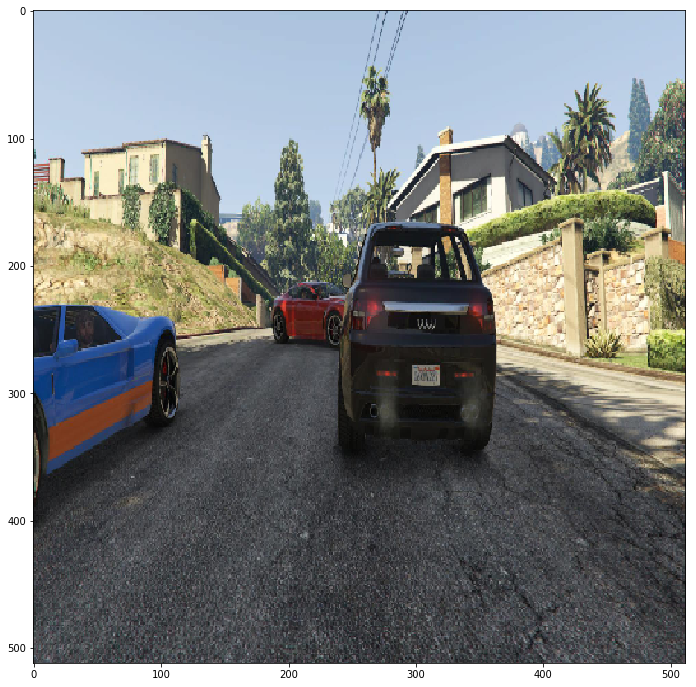

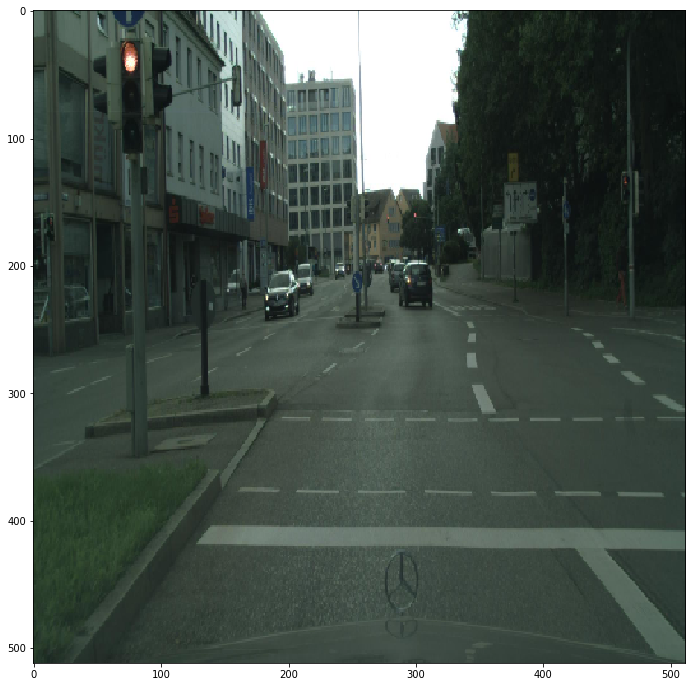

In [9]:
i = 1
print("Image:", batch_filenames[i])
colors = plt.cm.hsv(np.linspace(0, 1, n_classes+1)).tolist()

plt.figure(figsize=(20, 12))
plt.imshow(batch_images[0][i])
plt.show()
plt.figure(figsize=(20, 12))
plt.imshow(batch_images[1][i])
plt.show()


In [10]:
i = 0  # Which batch item to look at

print("Image:", batch_filenames[i])
print()
print("Ground truth boxes:\n")
print(np.array(batch_original_labels[i]))

# 3: Make predictions.

y_pred = model.predict(batch_images)[-1]

# Now let's decode the raw predictions in `y_pred`.

# Had we created the model in 'inference' or 'inference_fast' mode,
# then the model's final layer would be a `DecodeDetections` layer and
# `y_pred` would already contain the decoded predictions,
# but since we created the model in 'training' mode,
# the model outputs raw predictions that still need to be decoded and filtered.
# This is what the `decode_detections()` function is for.
# It does exactly what the `DecodeDetections` layer would do,
# but using Numpy instead of TensorFlow (i.e. on the CPU instead of the GPU).

# `decode_detections()` with default argument values follows the procedure of the original SSD implementation:
# First, a very low confidence threshold of 0.01 is applied to filter out the majority of the predicted boxes,
# then greedy non-maximum suppression is performed per class with an intersection-over-union threshold of 0.45,
# and out of what is left after that, the top 200 highest confidence boxes are returned.
# Those settings are for precision-recall scoring purposes though.
# In order to get some usable final predictions, we'll set the confidence threshold much higher, e.g. to 0.5,
# since we're only interested in the very confident predictions.

# 4: Decode the raw predictions in `y_pred`.

y_pred_decoded = decode_detections(y_pred,
                                   confidence_thresh=0.35,
                                   iou_threshold=0.4,
                                   top_k=200,
                                   normalize_coords=normalize_coords,
                                   img_height=img_height,
                                   img_width=img_width)

# We made the predictions on the resized images,
# but we'd like to visualize the outcome on the original input images,
# so we'll convert the coordinates accordingly.
# Don't worry about that opaque `apply_inverse_transforms()` function below,
# in this simple case it just applies `(* original_image_size / resized_image_size)` to the box coordinates.

# 5: Convert the predictions for the original image.

y_pred_decoded_inv = apply_inverse_transforms(y_pred_decoded, batch_inverse_transforms)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_decoded_inv[i])

# Finally, let's draw the predicted boxes onto the image.
# Each predicted box says its confidence next to the category name.
# The ground truth boxes are also drawn onto the image in green for comparison.

# 5: Draw the predicted boxes onto the image

# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, n_classes+1)).tolist()

plt.figure(figsize=(20, 12))
plt.imshow(batch_original_images[i])

current_axis = plt.gca()

for box in batch_original_labels[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    label = '{}'.format(classes[int(box[0])])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor': 'green', 'alpha': 1.0})

# for box in y_pred_decoded_inv[i]:
#     xmin = box[2]
#     ymin = box[3]
#     xmax = box[4]
#     ymax = box[5]
#     color = colors[int(box[0])]
#     label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
#     current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))
#     current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor': color, 'alpha': 1.0})

Image: ../../datasets/SIM10K/JPEGImages/3401768

Ground truth boxes:

[[  1  46 153 178 197]
 [  1 389 135 496 221]]


TypeError: 'list' object is not callable